This notebook attemps to solve the regression problem with housing data using the code templates developed for spark.
Version 1.1

In [1]:
%load_ext autoreload
%autoreload 2

#### Imports

###### Global Imports

In [2]:
import sys
sys.path.append(r"../")
from pprint import pprint

import pandas as pd
import numpy as np

In [3]:
from pyspark.sql import types as DT
from pyspark.sql import functions as F

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoderEstimator, Imputer
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

import dp
import features
# import model_gen
import model_eval
import utils

#### DATA READ

In [4]:
%%time
data = dp.read_data(spark=spark, path="/FileStore/tables/housing/housing.csv", fs="dbfs", fmt="csv", header="true", inferschema="true")
data.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.3 s


In [7]:
print(data.count())

20640


`target column`

In [6]:
target_col = 'median_house_value'

### Sampling

In [14]:
sample = dp.sampling(data,
                    target=target_col,
                    target_type ='continuous',#binary_categorical/continuous
                    max_sample_size=2000,
                    random_state=42,
                    stratify=False)

In [15]:
df = sample.toPandas()

In [17]:
df

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0       -122.25     37.84                52.0       2535.0           489.0   
1       -122.26     37.85                52.0       2202.0           434.0   
2       -122.26     37.85                52.0       3503.0           752.0   
3       -122.27     37.84                52.0       1503.0           298.0   
4       -122.27     37.83                48.0       1798.0           432.0   
...         ...       ...                 ...          ...             ...   
2089    -121.58     39.14                52.0        662.0           160.0   
2090    -121.57     39.16                33.0       2033.0           375.0   
2091    -121.57     39.16                18.0       1632.0           367.0   
2092    -121.54     39.12                17.0       4251.0           899.0   
2093    -121.57     39.10                28.0       1442.0           333.0   

      population  households  median_income  median_house_value  \
0         1094.0       514.0         3.6591            299200.0   
1          910.0       402.0         3.2031            281500.0   
2         1504.0       734.0         3.2705            241800.0   
3          690.0       275.0         2.6033            162900.0   
4          987.0       374.0         1.0972            104500.0   
...          ...         ...            ...                 ...   
2089       520.0       149.0         0.8928             55000.0   
2090       914.0       330.0         2.6964             68500.0   
2091       769.0       330.0         3.1029             71700.0   
2092      3265.0       934.0         2.3496             65000.0   
2093       832.0       286.0         1.8413             62300.0   

     ocean_proximity  
0           NEAR BAY  
1           NEAR BAY  
2           NEAR BAY  
3           NEAR BAY  
4           NEAR BAY  
...              ...  
2089          INLAND  
2090          INLAND  
2091          INLAND  
2092          INLAND  
2093          INLAND  

[2094 rows x 10 columns]

#### Identification of columns types in the data

In [22]:
%%time
num_cols = dp._list_numerical_columns( data)
cat_cols = dp._list_categorical_columns( data)   
bool_cols = dp._list_boolean_columns( data)
date_cols = dp._list_datelike_columns( data)
num_cols, cat_cols, bool_cols, date_cols

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.87 ms


(['longitude',
  'latitude',
  'housing_median_age',
  'total_rooms',
  'total_bedrooms',
  'population',
  'households',
  'median_income',
  'median_house_value'],
 ['ocean_proximity'],
 [],
 [])

#### Identification and Handling of Missing Values

In [29]:
print(data.count())
dp.identify_missing_values(data).show()

20640
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|           207|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



Only 1 column(total_bedrooms) with missing data. Handling them by imputing through mean.
 
 Other functionalities of missing values can be observed in dp module

In [32]:
%%time
imputer = dp.Imputer()
imputer.fit(data)

CPU times: user 62.5 ms, sys: 15.6 ms, total: 78.1 ms
Wall time: 6.68 s


Imputer_b787e2d8fb8e

In [33]:
imputed_data = imputer.transform(data)

In [34]:
%%time
dp.identify_missing_values(imputed_data).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|             0|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+

CPU times: user 0 ns, sys: 31.2 ms, total: 31.2 ms
Wall time: 2.39 s


#### Outlier Identification and Handling

In [ ]:
%%time
print(imputed_data.count())
outlier_handled_data = dp.handle_outliers(spark, imputed_data, cols=[], drop=True, cap=False, method='iqr', iqr_multiplier=1.5)
print(outlier_handled_data.count())

In the above function if drop=False and cap=True is input, instead of dropping the rows, the outliers will be capped to the relevant bounds.

More on this in features module

#### Encoding Categorical Features

As observed earlier ocean_proximity is the only categorical feature in this data.

In [ ]:
%%time 
# by default onehot encoding is used.
encoded_data = features.encode_categorical_features(spark, outlier_handled_data)

In [ ]:
encoded_data.printSchema()

In [37]:
target_col

'median_house_value'

#### Feature Elimination

functions available `feature_elimination_by_sparseness`, `feature_elimination_by_cv` ,`feature_elimination_by_missing_values`
`feature_elimination_by_correlation` , `feature_elimination_by_mutual_value`, `feature_elimination_by_lasso`

In [8]:
fe = features.FeatureEliminator(spark,data,target_col, target_type="continuous")

In [11]:
fe.transform(method='sparseness',threshold=0.1)

[]

In [12]:
fe.transform(method='cv',threshold=0.1)

['longitude', 'latitude']

In [13]:
fe.transform(method='missing_values',threshold=0.1)

([],
 {'longitude': 0.0,
  'latitude': 0.0,
  'housing_median_age': 0.0,
  'total_rooms': 0.0,
  'total_bedrooms': 0.01002906976744186,
  'population': 0.0,
  'households': 0.0,
  'median_income': 0.0,
  'median_house_value': 0.0,
  'ocean_proximity': 0.0})

In [14]:
fe.transform(method='correlation',threshold=0.1)

['longitude', 'population', 'households']

In [20]:
%%time
fe.transform(method='mutual_value',threshold=0.9)

CPU times: user 15.6 ms, sys: 141 ms, total: 156 ms
Wall time: 26.5 s


['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'ocean_proximity']

In [22]:
%%time
fe.transform(method='lasso',alpha=1)

CPU times: user 31.2 ms, sys: 15.6 ms, total: 46.9 ms
Wall time: 14.4 s


[]

#### Model DataPrep and Vector Generation

In [ ]:
%%time
outlier_indicators = [x for x in encoded_data.columns if 'outlier' in x]
index_columns = [x for x in encoded_data.columns if 'index' in x]
num_cols_1 = dp._list_numerical_columns(spark, encoded_data)
cat_cols_1 = dp._list_categorical_columns(spark, encoded_data)   
bool_cols_1 = dp._list_boolean_columns(spark, encoded_data)
date_cols_1 = dp._list_datelike_columns(spark, encoded_data)
pprint({'Numerical cols':num_cols_1, 'Categorical cols':cat_cols_1,'Boolean cols' : bool_cols_1,'Datetime cols' :date_cols_1})

In [ ]:
feature_cols = encoded_data.columns
feature_cols.remove(target_col)
feature_cols = [x for x in feature_cols if x not in index_columns]
feature_cols = [x for x in feature_cols if x not in outlier_indicators]
feature_cols = [x for x in feature_cols if x not in cat_cols_1]
feature_cols = [x for x in feature_cols if x not in date_cols_1]
feature_cols

In [ ]:
%%time
model_data = dp.generate_features_vector(spark, encoded_data, feature_cols, output_col="modeled_features")

In [ ]:
print(model_data.columns)

`Observe new column 'modeled_features' is created.`

#### Scaling 

In [ ]:
scaled_data = features.scale_data(spark,model_data,column='modeled_features',method='standard',prefix='scaled_') # other option is method = 'min_max'

In [ ]:
print(scaled_data.columns)

`Observe new column 'scaled_modeled_features' is created`

#### Train Test Split

In [ ]:
%%time
train_df, test_df = dp.test_train_split(spark, data=scaled_data, features_col="scaled_modeled_features", target_col=target_col, train_prop=0.7, random_seed=111)

In [ ]:
print((train_df.count(), len(train_df.columns)),train_df.columns)
print((test_df.count(), len(test_df.columns)),train_df.columns)

#### Model Train and Eval

In [27]:
model_gen.valid_model_types

['regression', 'classification']

In [28]:
pprint(model_gen.model_objects)

{'classification': {'decision_tree': {'estimator': 'pyspark.ml.classification.DecisionTreeClassifier',
                                      'model': 'pyspark.ml.classification.DecisionTreeClassifierModel'},
                    'gbt': {'estimator': 'pyspark.ml.classification.GBTClassifier',
                            'model': 'pyspark.ml.classification.GBTClassifierModel'},
                    'logistic': {'estimator': 'pyspark.ml.classification.LogisticRegression',
                                 'model': 'pyspark.ml.classification.LogisticRegressionModel'},
                    'multi_layer_perceptron': {'estimator': 'pyspark.ml.classification.MultilayerPerceptronClassifier',
                                               'model': 'pyspark.ml.classification.MultilayerPerceptronClassifierModel'},
                    'naive_bayes': {'estimator': 'pyspark.ml.classification.NaiveBayes',
                                    'model': 'pyspark.ml.classification.NaiveBayesModel'},
          

In [29]:
%%time
_model_str_ = 'linear_regression'
estimator = utils.load_class(model_gen.model_objects['regression'][_model_str_]['estimator'])
estimator

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 51.3 µs


pyspark.ml.regression.LinearRegression

In [30]:
%%time
_model_ = estimator(featuresCol="features", labelCol="y", predictionCol='yhat')
model = _model_.fit(train_df)
preds = model.transform(test_df)
print("Coefficients: " + str(model.coefficients))
print("Intercept: " + str(model.intercept))
preds.select("y","yhat").show(5)

Coefficients: [-49755.1387456918,-50484.36691606686,10413.402637675372,-14628.589510885748,30485.637897412827,-36166.493572686646,23286.673174594547,56545.0049853507,-78205.10756477053,-91524.65422930704,-52942.400376292135,-52358.3465711928]
Intercept: -1951633.857358671
+-------+------------------+
|      y|              yhat|
+-------+------------------+
|76100.0| 171576.2076803462|
|78300.0| 129096.5361062712|
|58100.0| 136995.0602729288|
|66900.0|114746.66766776796|
|90100.0| 184371.2885959216|
+-------+------------------+
only showing top 5 rows

CPU times: user 31.2 ms, sys: 15.6 ms, total: 46.9 ms
Wall time: 26.5 s


#### Model Evaluation Metrics

In [31]:
%%time
reg_metrics = model_eval.get_regression_metrics(spark, data=preds, y_col='y' , y_pred_cols=['yhat'])
reg_metrics.show()

/home/emp/miniconda3/lib/python3.7/site-packages/pyspark/sql/session.py:776: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.8.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


+------------------+-------------------+
|            metric|               yhat|
+------------------+-------------------+
|Explained Variance|   0.37365392070588|
|              RMSE| 57715.544702894505|
|               MAE| 42770.326835084874|
|               MSE|3.331084100351814E9|
|              MAPE|0.26972165972227635|
|             WMAPE| 0.2289457997333555|
|              R.Sq| 0.6262650820032474|
+------------------+-------------------+

CPU times: user 46.9 ms, sys: 0 ns, total: 46.9 ms
Wall time: 30.2 s


#### Regression Plots

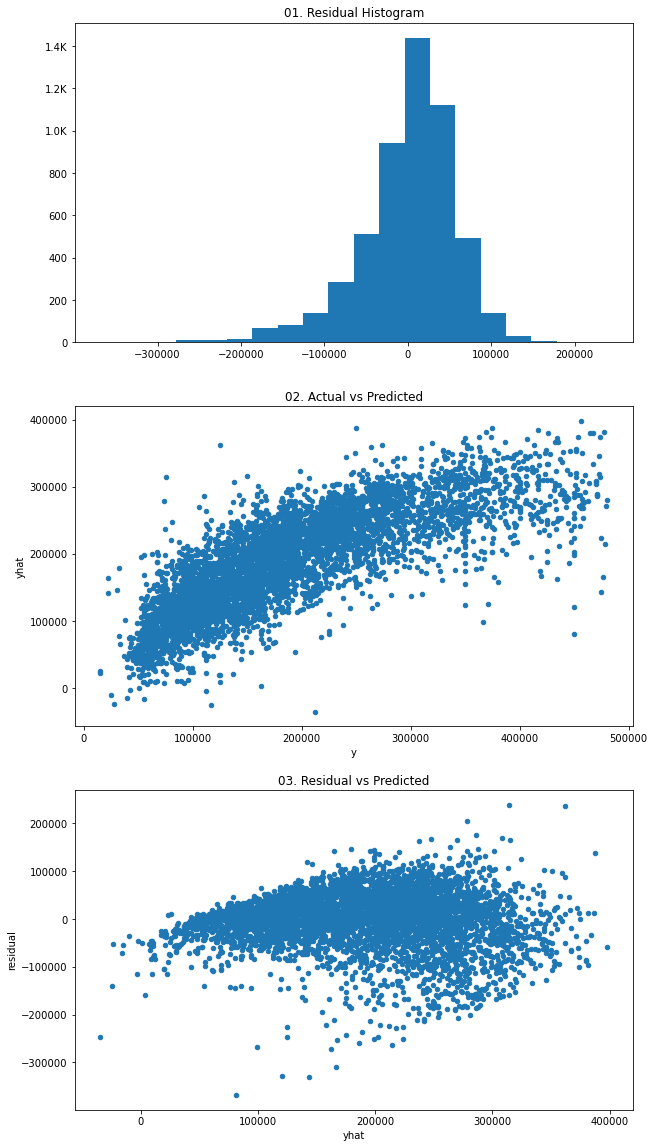

CPU times: user 453 ms, sys: 62.5 ms, total: 516 ms
Wall time: 16.5 s


In [32]:
%%time
model_eval.generate_regression_plots(spark, preds, 'y', 'yhat')